<a href="https://colab.research.google.com/github/ysinjab/traffic/blob/master/accidents_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Predict if road (under some situations) is dangeraous:

The idea is to build a classifier that predict if the road is dangerous or not. Based on the features for any accidents that has dead_number greater than zero. Idea to improve is by adding injuries numbers too the target.

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import lightgbm as lgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn import metrics
from sklearn import model_selection
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import  KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from yellowbrick.classifier import  ConfusionMatrix, ROCAUC
from yellowbrick.model_selection import LearningCurve
from catboost import CatBoostClassifier


import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook, tqdm
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Prepare dataset
This step includes combining date and time to datetime and make its components as features



In [0]:
def get_dataset():
  accidents_df = pd.read_csv('/content/drive/My Drive/accidents.csv', index_col=0)
  accidents_df = accidents_df.rename(str.lower, axis='columns')
  accidents_df['accident_dt'] = accidents_df['accident_date_g'] + ' ' + accidents_df['accident_time']
  accidents_df['accident_dt'] = pd.to_datetime(accidents_df['accident_dt'])
  accidents_df = accidents_df.drop(['accident_date_g', 'accident_time'], axis=1)
  accidents_df['year'] = accidents_df['accident_dt'].dt.year
  accidents_df['month'] = accidents_df['accident_dt'].dt.month
  accidents_df['day'] = accidents_df['accident_dt'].dt.day
  accidents_df['hour'] = accidents_df['accident_dt'].dt.hour
  accidents_df['minute'] = accidents_df['accident_dt'].dt.minute
  return accidents_df

#  Create model :



In [0]:
features = ['road_type', 'road_status', 'weather_status',
            'small_truck', 'big_truck', 'animal', 'paints', 
            'eyes', 'geometric_roadtype', 'dead_number']
df = get_dataset()
df = df[features]

# create baseline classifier
X = df[~df.dead_number.isnull()].fillna(-1)
y = X.dead_number.apply(lambda x: x > 0)

X = X.drop('dead_number', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

Baseline model

In [0]:
dummy_clf = DummyClassifier(strategy='uniform', random_state=42)
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_test, y_test)

0.4987868985038415

Use catboost classifier

In [0]:
cat_clf = CatBoostClassifier(iterations=2,
                             learning_rate=1,
                             depth=2,
                             cat_features=X_train.columns)
cat_clf.fit(X_train, y_train.astype(int))
cat_clf.score(X_test, y_test)

0:	learn: 0.3925455	total: 9.03ms	remaining: 9.03ms
1:	learn: 0.3808439	total: 16.6ms	remaining: 0us


0.8708046906591185

Let's check the classifiers performance by checking:
* Precision how many of the samples predicted as positive are actually positive.
* Recall how many of the positive samles are captured by positive predictions.
* f1 score is harmonic mean of both : 0 is the worst , 1 is the best

In [0]:
y_predicted = dummy_clf.predict(X_test)
print(classification_report(y_test, y_predicted))

y_predicted = cat_clf.predict(X_test)
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

       False       0.87      0.50      0.63      4307
        True       0.13      0.49      0.20       639

    accuracy                           0.50      4946
   macro avg       0.50      0.50      0.42      4946
weighted avg       0.77      0.50      0.58      4946

              precision    recall  f1-score   support

       False       0.87      1.00      0.93      4307
        True       0.00      0.00      0.00       639

    accuracy                           0.87      4946
   macro avg       0.44      0.50      0.47      4946
weighted avg       0.76      0.87      0.81      4946



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


How much we benefit from adding more training data?

* Figure 1: There is a gap between the validation score and training score using dummy classifier. Both they don't converge and adding more data may help.
* Figure 2: For the Catboost decision tree classifier: although score has started with high value, but it drops immediately to be almost in the same value of cross validation score. And the more of samples increase, both are in pleateau. So adding more samples won't help.


Note: if classifier is used in learning_curve, StratifiedKFold is used internally.

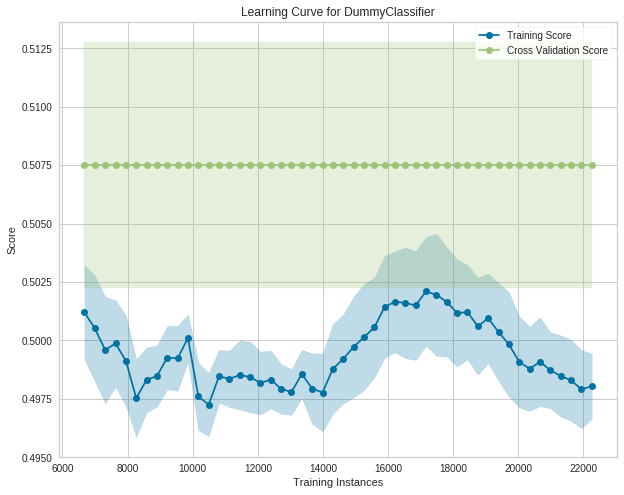

In [0]:
fig, ax = plt.subplots(figsize=(10, 8))
cv = model_selection.StratifiedKFold(10)
lc_viz = LearningCurve(dummy_clf,
                       cv=cv,
                       train_sizes=np.linspace(0.3, 1.0, 50),
                       scoring='accuracy',
                       n_jobs=-1)
lc_viz.fit(X, y)
lc_viz.poof()

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


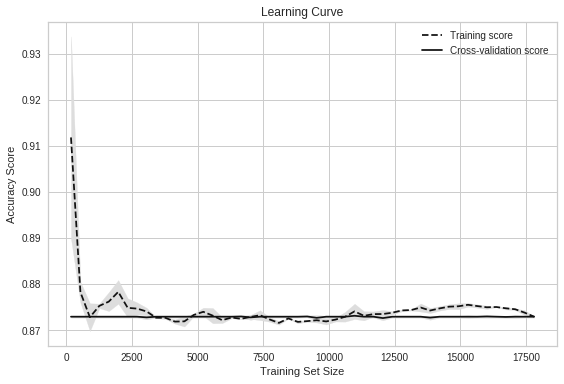

In [0]:
train_sizes, train_scores, test_scores = learning_curve(cat_clf,
    X_train,
    y_train.astype(int),
    cv=10,
    scoring='accuracy',
    n_jobs=-1,
    train_sizes=np.linspace(0.01, 1.0))

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

plt.fill_between(train_sizes, train_mean - train_std,
                 train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std,
                 test_mean + test_std, color="#DDDDDD")
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"),
plt.legend(loc="best")
plt.tight_layout()
plt.show()